# Projeto: DESAFIO EMPIRICUS – CURSO DATA SCIENCE

## Nome: Johnny Hideki Horita




### Importando bibliotecas

<a href="https://pypi.org/project/Faker/">Faker</a></br>
pip install Faker</br>
Faker é um pacote Python que gera dados falsos.</br>

<a href="https://pypi.org/project/pandas/">Pandas</a></br>
pip install pandas</br>
Poderosas estruturas de dados para análise de dados, séries cronológicas e estatísticas.</br>

<a href="https://pypi.org/project/matplotlib/">matplotlib</a></br>
pip install matplotlib</br>
Pacote de "plotagem".</br>

<a href="https://pypi.org/project/numpy/">numpy</a></br>
pip install numpy</br>
NumPy é o pacote fundamental para a computação de array com Python.</br>

<a href="https://pypi.org/project/seaborn/">seaborn</a></br>
pip install seaborn</br>
visualização de dados estatísticos.</br>

<a href="https://pypi.org/project/scikit-surprise/">scikit-surprise</a></br>
pip install scikit-surprise</br>
Uma biblioteca fácil de usar para sistemas de recomendação.</br>

<a href="https://pypi.org/project/scikit-learn/">scikit-learn</a></br>
pip install scikit-learn</br>
Um conjunto de módulos python para aprendizagem de máquinas e mineração de dados.</br>

<a href="https://pypi.org/project/tensorflow-recommenders/">tensorflow-recommenders</a></br>
pip install tensorflow-recommenders</br>
Uma biblioteca TensorFlow para sistemas de recomendação.</br>


In [1]:
import os
import json
import random
from collections import Counter
from faker import Faker

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise import SVD
from surprise.model_selection import train_test_split, cross_validate, KFold
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

%matplotlib inline

### Parametros Gerais

In [2]:
# Parametros
#pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)


# Definição de padrões para gráficos e cores
sns.set_style('darkgrid')  # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)          # controls default text sizes

# deep, pastel, Set1 Set2 Set3, icefire, tab10, muted, colorlind, coolwarm
colors = sns.color_palette("pastel")
cmap_colors = 'GnBu'

font_path = "./fonts/CabinSketch-Bold.ttf"

# Instanciando variavel Faker
faker = Faker()

### Funções

In [3]:
# Função para gerar lista com elementos randomicos

def fn_randomList(listaItem, qtdItem):
    """    
    Função para gerar lista com elementos randomicos

    Returns:
    list: Lista de elementos
    """
    return random.choices(listaItem, weights=None, cum_weights=None, k=qtdItem)

In [4]:
# Função para gerar CPF

def fn_geraCPF():
    """
    Função para gerar CPF

    Returns:
    string: CPF
    """
    cpf = [random.randrange(10) for _ in range(9)]

    for _ in range(2):
        value = sum([(len(cpf) + 1 - i) * v for i, v in enumerate(cpf)]) % 11
        cpf.append(11 - value if value > 1 else 0)

    return "".join(str(x) for x in cpf)

In [5]:
# Função para gerar os Produtos (Assinaturas e Cursos) adquiridos

def fn_geraProdutosAdquiridos(qtMaximaProdutos):
    """
    Função para gerar Produtos (Assinaturas e Cursos) adquiridos

    Parametros:
    qtMaximaProdutos (int): quantidade máxima produtos que o usuário pode ter;

    Returns:
    Dataframe: Produtos
               produto
               ativo
               pagamento
    """
    # define randomicamente a quantidade de produtos que um usuário pode possuir
    qtdItem = random.randint(1, qtMaximaProdutos)

    # Gera a lista de produtos do usuário
    listUsuarioProdutos = fn_randomList(listProduto, qtdItem)

    # Redefindo a lista apenas com produtos únicos
    listUsuarioProdutos = list(set(listUsuarioProdutos))

    # Atualiza a quantidade real de itens da lista
    qtdItem = len(listUsuarioProdutos)

    # Gera a lista de forma de pagamentos dos produtos
    listUsuarioFormaPgtos = fn_randomList(listFormaPgto, qtdItem)

    # Gera a lista de produtos ativos e cancelados
    #listProdutosAtivos = [random.randint(0, 1) for _ in range(qtdItem)]
    listProdutosAtivos = random.choices([1, 0], weights=[70, 30], k=qtdItem)

    # Gera a lista de Notas atribuidas ao produto de 0 à 5
    #listProdutosNota = [random.randint(0, 5) for _ in range(qtdItem)]

    # Carregando as listas em dataframe
    produtosAdquiridos = pd.DataFrame(
        {'produto': listUsuarioProdutos, 'ativo': listProdutosAtivos, 'pagamento': listUsuarioFormaPgtos
         # ,'nota': listProdutosNota
         })

    return produtosAdquiridos

In [6]:
# Função para gerar os produtos que o usuário tem

def fn_geraUsuarioProdutos(listCep):
    """
    Função para gerar os produtos que o usuário tem

    Parametros:
    listCep (list): Lista de CEP;

    Returns:
    Dataframe: Usuário produtos
               cpf
               dataNascimento
               cep
               produto
               ativo
               pagamento
    """
    # Gera dataframe de produtos adquiridos pelo usuário
    usuarioProdutos = fn_geraProdutosAdquiridos(qtMaximaProdutos)

    # Gera cpf e adiciona coluna ao dataframe
    usuarioProdutos.insert(0, 'cpf', fn_geraCPF())

    # Gera data de nascimento e adiciona coluna ao dataframe
    usuarioProdutos.insert(1, 'dataNascimento', faker.date_of_birth())

    # Gera cep e adiciona coluna ao dataframe
    usuarioProdutos.insert(2, 'cep', faker.words(
        nb=1, ext_word_list=listCep, unique=True)[0])

    return usuarioProdutos

In [7]:
# Função para gerar o cadastro de usuários

def fn_geraCadastroUsuarios(listCep, qtUsuarios=10):
    """
    Função para gerar o Cadastro de usuários

    Parametros:
    listCep (list): Lista de CEP;
    qtUsuarios (int): Quantidade de usuários para criar;

    Returns:
    Dataframe: Cadastro de Usuário
               cpf
               dataNascimento
               cep
               produto
               ativo
               pagamento
    """

    cadatroUsuarios = fn_geraUsuarioProdutos(listCep)
    for i in range(qtUsuarios):
        usuarioProdutos = fn_geraUsuarioProdutos(listCep)
        cadatroUsuarios = pd.concat(
            [cadatroUsuarios, usuarioProdutos], ignore_index=True)

    return cadatroUsuarios

In [8]:
# Função para calcular a média ponderada de cada produto

def fn_classificacaoPonderada(v, m, R, C):
    """
    Função para calcular a média ponderada de cada produto

    Parametros:
    v (float): classificação média para cada item 
    m (float): votos mínimos necessários para ser classificado como popular
    R (pd.Series): classificação média para o item
    C (pd.Series): classificação média para todo o conjunto de dados 

    Returns:
    pd.Series: Calculo da média ponderada
    """
    return ((v / (v + m)) * R) + ((m / (v + m)) * C)

In [9]:
# Função para calcular a pontuação popular baseada na média ponderada.

def fn_classificacaoPopular(dfPrincipal, dfProduto, userCol, itemCol, classificacaoCol):
    '''
    Função para calcular a pontuação popular baseada na média ponderada.

    Parametros:
    dfPrincipal (DataFrame): DataFrame com o identificador, item, classificação
    dfPrincipal (DataFrame): DataFrame com os itens 
    UserCol (string, int): identificador
    itemCol (string, int): item para classificação popular
    classificacaoCol (int): valor da classificação do usuário

    Returns
    Dataframe -> pd.DataFrame contém item e pontuação ponderada.
    '''

    classificacao = (
        dfPrincipal
        .groupby(itemCol, as_index=False)
        .agg({userCol: 'count', classificacaoCol: 'mean'})
    )
    classificacao.columns = [itemCol, 'qtclassificacao', 'mediaclassificacao']

    # calcula os parametros de entrada 
    C = np.mean(classificacao['mediaclassificacao'])
    m = np.percentile(classificacao['qtclassificacao'], 0)
    classificacao = classificacao[classificacao['qtclassificacao'] >= m]
    R = classificacao['mediaclassificacao']
    v = classificacao['qtclassificacao']
    classificacao['pontuacao'] = fn_classificacaoPonderada(v, m, R, C)

    # post processing
    classificacaoPopular = classificacao.merge(dfProduto, on=[itemCol], how='left')

    return classificacaoPopular

In [10]:
# Função para correlação e ordenação do produto

def fn_recomendacaoProdutos(produto, qtProduto, corrMat, mapName):
    """
    Função para correlação e ordenação do produto

    Parametros:
    produto (str): 
    qtProduto (int): quantidade de produtos para recomendação;
    corrMat (dataframe): matriz de correção;
    mapName (dataframe): nome das colunas;

    Returns:
    DataFrame
    """
    topProdutos = corrMat[produto, :].argsort()[-qtProduto:][::-1]
    topProdutos = [mapName[e] for e in topProdutos]
    return topProdutos

In [11]:
# Função para plotar gráfico de barras

def fn_GrafBarras(df, col):
    """
    Função para plotar gráfico de barras

    Parametros:
    df (DataFrame): DataFrame
    col (string): variável ;

    Returns:
    image: Gráfico de barras

    """
    total = len(df)

    plt.figure(figsize=(12, 6))
    g = sns.countplot(x=col, data=df, palette=colors)
    g.set_title(f"Distribuição da variável {col}")
    g.set_xlabel(f"{col}")
    g.set_ylabel("Quantidade")
    sizes = []
    for p in g.patches:
        height = p.get_height()
        sizes.append(height)
        g.text(p.get_x()+p.get_width()/2.,
               height + 3,
               '{:1.2f}%'.format((height/total)*100),
               ha="center", fontsize=14)
    g.set_ylim(0, max(sizes) * 1.15)
    plt.show()

In [12]:
# Função de avaliação dos valores de NaN no dataframe

def missing_values_table(df):
    """
    Função para verificar se existem valores nulos no dataframe

    Parametros:
    df (dataframe): Dataframe;

    Returns: 
    Apresentação dos valores nulos no dataframe.

    """
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mz_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mz_table = mz_table.rename(
        columns={0: 'Valores faltantes', 1: '% de Valores Totais'})
    mz_table['Data Type'] = df.dtypes
    mz_table = mz_table[
        mz_table.iloc[:, 1] != 0].sort_values(
        '% de Valores Totais', ascending=False).round(1)
    print("O dataframe tem " + str(df.shape[1]) + " colunas e " + str(df.shape[0]) + " linhas.\n"
          "Existem " + str(mz_table.shape[0]) +
          " colunas que têm valores faltantes.")
    #mz_table.to_excel('missing_and_zero_values.xlsx', freeze_panes=(1,0), index = True)
    return mz_table

### Preparando dataframes para elaboração de Cadastro de Usuários

#### Dataframe CEP

Para a criação do dataframe de CEP utilizei o arquivo <b>ceps-utf8.txt</b> do site <a href="http://cep.la">CEP lá.</a></br>
Download: http://cep.la/CEP-dados-2018-UTF8.zip


In [13]:
%%time

# Criando dataframe de ceps
CEP = pd.read_csv('ceps-utf8.txt', delimiter="\t", lineterminator="\n",)

# Encontrando a posição de '/'
CEP['pos'] = CEP['estado'].str.find('/')

CEP['sigla'] = CEP.estado.str.slice(CEP.pos+1, 2)

# Adicionando coluna com a sigla do estado
CEP['sigla'] = CEP.apply(lambda x: x['estado'][x['pos']+1:x['pos']+3], axis=1)

Wall time: 12.5 s


In [14]:
%%time

# Região Norte
listCepNorte = CEP["cep"][CEP['estado'].str.contains(
    "/AC|/AM|/AP|/PA|/RO|/RR|/TO")].values.tolist()

# Região Nordeste
listCepNordeste = CEP["cep"][CEP['estado'].str.contains(
    "/AL|/BA|/CE|/MA|/PI|/PE|/PB|/RN|/SE")].values.tolist()

# Região Centro-Oeste
listCepCentroOeste = CEP["cep"][CEP['estado'].str.contains(
    "/GO|/MT|/MS|/DF")].values.tolist()

# Região Sul
listCepSul = CEP["cep"][CEP['estado'].str.contains(
    "/PR|/RS|/SC")].values.tolist()

# Região Sudeste
listCepSudeste = CEP["cep"][CEP['estado'].str.contains(
    "/ES|/MG|/RJ|/SP")].values.tolist()

# Todas as Regiões
listCep = CEP["cep"].values.tolist()

Wall time: 1.55 s


#### Dataframe Produtos (Assinaturas e Cursos)

Para a criação das informações de Cursos e devido a sua quantidade importei a página https://publicacoes.empiricus.com.br/cursos/todos-cursos manualmente para um arquivo json utilizando a extensão html to figma.

Para a criação das informações de Assinaturas, o processo foi feito de forma manual, pois não existe uma quantidade alta para um processo automatizado. 


##### Cursos

In [15]:
# Carregando arquivo json

# instanciando variavel com o nome do arquivo
jsonFile = 'publicacoes-Cursos-Todos-cursos.json'

# Abrindo arquivo JSON
f = open(jsonFile, encoding="utf-8")

# Instanciando variavel data com o arquivo json
data = json.load(f)

# Fechando o arquivo
f.close()

In [16]:
# Processo para "ler" a estrutura json, carregando os títulos do curso e autor em listas e gravar em dataframe

# Criando lista vazias
courseList = []
authorList = []

# Define o tipo de produto
# 1 = Curso
# 2 = Assinatura

tipo = 1  # tipo = Curso

# loop para carregar os cursos a partir do arquivo json
p = 1
for i in range(len(data['layers'])):
    if (i >= 320 and i <= 556):
        if (data['layers'][i]['characters'] != 'Conhecer curso'):
            el = data['layers'][i]['characters']
            if (p == 1):
                courseList.append(el)
                title = 'Curso'
                p = 0
            else:
                authorList.append(el)
                title = 'Autor(a)'
                p = 1

            #print(f"{title}: {el}")

# Carregando as listas em dataframe
empiricusProduto = pd.DataFrame(
    {'produto': courseList,
     'tipo': 'Curso',
     'autor': authorList
     })

##### Assinaturas

In [17]:
# Carregando o produto Assinaturas

# Criando lista de Assinaturas
assinList = [['As melhores Ações da Bolsa', 'Assinatura', 'Fernando Ferrer'],
             ['Double Income', 'Assinatura', 'Felipe Miranda'],
             ['Empiricus Crypto Legacy', 'Assinatura', 'Vinicius Bazan'],
             ['O Investidor Internacional', 'Assinatura', 'João Piccioni'],
             ['Os Melhores Fundos de Investimento', 'Assinatura', 'Bruno Mérola'],
             ['Palavra do Estrategista', 'Assinatura', 'Felipe Miranda'],
             ['Renda Imobiliária', 'Assinatura', 'Caio Araujo'],
             ['Super Renda Fixa', 'Assinatura', 'Laís Helena Camargo Costa'],
             ['Top 5 Crypto', 'Assinatura', 'Ray Nasser'],
             ['Vacas Leiteiras', 'Assinatura', 'Rodolfo Amstalden'],
             ['Exponential Coins', 'Assinatura', 'Vinicius Bazan']
             ]

# Carregando a lista de assinatura para o dataframe
empiricusProduto = empiricusProduto.append(pd.DataFrame(assinList,
                                                        columns=['produto', 'tipo', 'autor']),
                                           ignore_index=True)

##### Dataframe Produtos

In [18]:
# Exibição do dataframe de Produtos com os Cursos e Assinaturas
display(empiricusProduto)

# Gerando uma lista de produtos
listProduto = empiricusProduto["produto"].values.tolist()

,produto,tipo,autor
0,CryptoXpress,Curso,Narriman França
1,Mentoria Bitcamp,Curso,Ray Nasser
2,Assistente de Arrematação 4.0,Curso,Lerry Granville
3,Lucrando com Automóveis 7.0,Curso,Lerry Granville
4,Seu Primeiro Trade,Curso,Filipe Fradinho
...,...,...,...
85,Renda Imobiliária,Assinatura,Caio Araujo
86,Super Renda Fixa,Assinatura,Laís Helena Camargo Costa
87,Top 5 Crypto,Assinatura,Ray Nasser
88,Vacas Leiteiras,Assinatura,Rodolfo Amstalden


#### Lista Formas de Pagamentos

Para geração das formas de pagamentos criei uma lista definida conforme a cobrança oferecida pela Empiricus.

0. Cartão de Crédito
1. Boleto 
2. Transferência
3. Carteiras Digitais


In [19]:
# Gerando dataframe utilizando dicionário

# Criando dicionário com as formas de pagamento
listFormaPgto = ['Cartão de Crédito', 'Boleto',
                 'Transferência', 'Carteiras Digitais']

In [20]:
# Exibição do dataframe de Formas de pagamentos
listFormaPgto

['Cartão de Crédito', 'Boleto', 'Transferência', 'Carteiras Digitais']

#### Dataframe Assinturas e Cursos Ativos e Cancelados

Para a criação de produtos ativos e cancelados pelo usuário criei a função <b>fn_geraProdutosAdquiridos</b> para geração de dataframe indicando as assinaturas ativas e cancelados com as suas respectivas formas de pagamento.

Os comandos abaixo representam a simulação da função para apresentação didática.

In [21]:
# define a quantidade máxima de produtos
qtMaximaProdutos = 15

# define randomicamente a quantidade de produtos que um usuário pode possuir
qtdItem = random.randint(1, qtMaximaProdutos)

# Gera a lista de produtos do usuário
listUsuarioProdutos = fn_randomList(listProduto, qtdItem)

# Redefindo a lista apenas com produtos únicos
listUsuarioProdutos = list(set(listUsuarioProdutos))

# Atualiza a quantidade real de itens da lista
qtdItem = len(listUsuarioProdutos)

# Gera a lista de forma de pagamentos dos produtos
listUsuarioFormaPgtos = fn_randomList(listFormaPgto, qtdItem)

# Gera a lista de produtos ativos e cancelados
listProdutosAtivos = random.choices([1, 0], weights=[60, 40], k=qtdItem)

# Gera a lista de Notas atribuidas ao produto
#listProdutosNota = [random.randint(0, 5) for _ in range(qtdItem)]

In [22]:
# Carregando as listas em dataframe
usuarioProdutos = pd.DataFrame(
    {'produto': listUsuarioProdutos,
     'pagamento': listUsuarioFormaPgtos,
     'ativo': listProdutosAtivos
     })

In [23]:
usuarioProdutos

,produto,pagamento,ativo
0,Copy Camp Platinum - Turma 2,Transferência,1
1,Investidor Definitivo,Cartão de Crédito,0
2,Microcap Hunter,Boleto,1
3,Beat The Dealer,Carteiras Digitais,1
4,Portfólio Antifrágil,Carteiras Digitais,1


### Cadastro de usuários ficticios


Para a criação de usuários ficticios criei a função <b>fn_geraCadastroUsuario</b> para geração de dataframe conforme informações do usuário.

Temos as seguintes informações dos usuários (fictícias):</br>

•	CPF</br>
•	Data de Nascimento</br>
•	CEP</br>
•	Assinaturas e Cursos ativos</br>
•	Assinaturas e Cursos cancelados</br>
•	Formas de Pagamento usadas nas compras anteriores</br>

Os comandos abaixo representam a simulação da função para apresentação didática.


#### Dataframe de Produtos (Assinaturas e Cursos) do usuário

In [24]:
# Gera dataframe de produtos adquiridos pelo usuário
usuarioProdutos = fn_geraProdutosAdquiridos(qtMaximaProdutos)

# Gera cpf e adiciona coluna ao dataframe
usuarioProdutos.insert(0, 'cpf', fn_geraCPF())

# Gera data de nascimento e adiciona coluna ao dataframe
usuarioProdutos.insert(1, 'dataNascimento', faker.date_of_birth())

# Gera cep e adiciona coluna ao dataframe
usuarioProdutos.insert(2, 'cep', faker.words(
    nb=1, ext_word_list=listCep, unique=True)[0])

# Exibe o cadastro de usuário
usuarioProdutos

,cpf,dataNascimento,cep,produto,ativo,pagamento
0,27137380166,2012-07-30,4265060,Renda Imobiliária,1,Boleto
1,27137380166,2012-07-30,4265060,Seu Primeiro Trade,0,Transferência
2,27137380166,2012-07-30,4265060,Trader de Fim de Semana,0,Boleto
3,27137380166,2012-07-30,4265060,Quarentena Milionária,1,Cartão de Crédito


#### Dataframe de Usuários ficticios

Com base nas informações do investidor brasileiro obtidos pelo site da 
<a href="https://www.anbima.com.br/pt_br/especial/raio-x-do-investidor-2021.htm#">Ambima (Raio-X Investidor)</a>, os investidores estão separados com a seguinte proporção:

48% - Sudeste</br>
17% - Nordeste</br>
15% - Sul</br>
14% - Centro-Oeste</br>
06% - Norte</br>

Regiões do Brasil</br>
<b>Norte:</b> Acre, Amazonas, Amapá, Pará, Rondônia, Roraima e Tocantins.</br>
<b>Nordeste:</b> Alagoas, Bahia, Ceará, Maranhão, Piauí, Pernambuco, Paraíba, Rio Grande do Norte e Sergipe.</br>
<b>Centro-Oeste:</b> Goiás, Mato Grosso, Mato Grosso do Sul e o Distrito Federal.</br>
<b>Sul:</b> Paraná, Rio Grande do Sul e Santa Catarina.</br>
<b>Sudeste:</b> Espírito Santo, Minas Gerais, Rio de Janeiro e São Paulo</br>

Tempo de geração do Cadastro de usuários:</br>
10_000 = 20 seg</br>
20_000 = 46 seg</br>
30_000 = 83 seg</br>
40_000 = 128 seg</br>


In [25]:
%%time

# Gera o cadastro de usuários ficticios
qtUsuarios = 40_000

cadUsuSudestes = fn_geraCadastroUsuarios(listCepSudeste, int(qtUsuarios * 0.48))
cadUsuNordeste = fn_geraCadastroUsuarios(listCepNordeste, int(qtUsuarios * 0.17))
cadUsuSul = fn_geraCadastroUsuarios(listCepSul, int(qtUsuarios * 0.15))
cadUsuCentroOeste = fn_geraCadastroUsuarios(listCepCentroOeste, int(qtUsuarios * 0.14))
cadUsuNorte = fn_geraCadastroUsuarios(listCepNorte, int(qtUsuarios * 0.06))

cadatroUsuarios = pd.concat([cadUsuSudestes, cadUsuNordeste, cadUsuSul, cadUsuCentroOeste, cadUsuNorte], ignore_index=True)

Wall time: 2min


### Análise de consistência dos dados

#### Usuários

In [26]:
# Quantidade de linhas e colunas
qtl, qtc = cadatroUsuarios.shape

# Quantidade de linhas duplicadas
qtd, _ = cadatroUsuarios[cadatroUsuarios.duplicated(keep=False)].shape

print(f'Quantidade de linhas...........: {qtl}')
print(f'Quantidade de linhas duplicadas: {qtd}')
print(f'Quantidade de colunas..........: {qtc}')

Quantidade de linhas...........: 303967
Quantidade de linhas duplicadas: 0
Quantidade de colunas..........: 6


In [27]:
# Informações do dataframe
cadatroUsuarios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303967 entries, 0 to 303966
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   cpf             303967 non-null  object
 1   dataNascimento  303967 non-null  object
 2   cep             303967 non-null  int64 
 3   produto         303967 non-null  object
 4   ativo           303967 non-null  int64 
 5   pagamento       303967 non-null  object
dtypes: int64(2), object(4)
memory usage: 13.9+ MB


In [28]:
# Avaliando os valores nulos do dataframe
missing_values_table(cadatroUsuarios)

O dataframe tem 6 colunas e 303967 linhas.
Existem 0 colunas que têm valores faltantes.


,Valores faltantes,% de Valores Totais,Data Type


In [29]:
# Exibição das primeiras linhas do dataframe
cadatroUsuarios.head()

,cpf,dataNascimento,cep,produto,ativo,pagamento
0,38005904843,2005-03-01,17505060,Crypto Staking,1,Carteiras Digitais
1,38005904843,2005-03-01,17505060,Lucrando com Automóveis 2.0,1,Boleto
2,38005904843,2005-03-01,17505060,Investidor Essencial com Felipe Miranda,1,Transferência
3,38005904843,2005-03-01,17505060,Vacas Leiteiras,1,Transferência
4,38005904843,2005-03-01,17505060,Os Melhores Fundos de Investimento,1,Boleto


#### Cadastro de Produtos (Assinaturas e Cursos)

In [30]:
# Quantidade de linhas e colunas
qtl, qtc = empiricusProduto.shape

# Quantidade de linhas duplicadas
qtd, _ = empiricusProduto[empiricusProduto.duplicated(keep=False)].shape

print(f'Quantidade de linhas...........: {qtl}')
print(f'Quantidade de linhas duplicadas: {qtd}')
print(f'Quantidade de colunas..........: {qtc}')

Quantidade de linhas...........: 90
Quantidade de linhas duplicadas: 0
Quantidade de colunas..........: 3


In [31]:
# Informações do dataframe
empiricusProduto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   produto  90 non-null     object
 1   tipo     90 non-null     object
 2   autor    90 non-null     object
dtypes: object(3)
memory usage: 2.2+ KB


In [32]:
# Avaliando os valores nulos do dataframe
missing_values_table(empiricusProduto)

O dataframe tem 3 colunas e 90 linhas.
Existem 0 colunas que têm valores faltantes.


,Valores faltantes,% de Valores Totais,Data Type


In [33]:
# Exibição das primeiras linhas do dataframe
empiricusProduto.head()

,produto,tipo,autor
0,CryptoXpress,Curso,Narriman França
1,Mentoria Bitcamp,Curso,Ray Nasser
2,Assistente de Arrematação 4.0,Curso,Lerry Granville
3,Lucrando com Automóveis 7.0,Curso,Lerry Granville
4,Seu Primeiro Trade,Curso,Filipe Fradinho


### Pré-processamento e transformações

#### Popularidade do produto (Assinaturas e Cursos)

Para o problema de aprendizagem da máquina, precisamos de um modelo ou método de base para utilizar como referência, seja boa ou não.</br>
Para o sistema de recomendação, vou criar uma simples linha de pontuação base com recomendação do produto mais populares.</br>
Para definir a popularidade do produto, utilizei uma métrica chamada sistema de classificação ponderada que é utilizada para pontuar a classificação de cada produto.</br>


##### Definição da variável Categoria 

A inclusão da variável Categoria  ao produto facilitará no agrupamento de assinaturas e cursos, definindo uma característica ao produto.</br>
Por exemplo, se um usuário gostou de um produto, então este algoritmo recomendará produtos que se enquadram na mesmo Categoria.</br>
Assim pretendo criar uma melhor forma de recomendação, introduzindo outras características do conteúdo no algoritmo.</br>


In [34]:
# Criação de um novo DataFrame para definir o genero do produto
empiricusProdutoCategoria = empiricusProduto

# Adicionando coluna genero por produto com o valor 'Renda Extra'
empiricusProdutoCategoria['categoria'] = 'Renda Extra'

# Definindo o genero dos produtos
empiricusProdutoCategoria.loc[empiricusProdutoCategoria['produto'].str.contains(
    'Leilões|Lucrando|Copy|Microcap|Mentoria Renda|Game'), ['categoria']] = 'Renda Extra'

empiricusProdutoCategoria.loc[empiricusProdutoCategoria['produto'].str.contains(
    'Investidor|Portfólio|Day Trade'), ['categoria']] = 'Ações e Futuros'

empiricusProdutoCategoria.loc[empiricusProdutoCategoria['produto'].str.contains(
    'Milionária|Jornada|Milhão'), ['categoria']] = 'Bolsa de Valores'

empiricusProdutoCategoria.loc[empiricusProdutoCategoria['produto'].str.contains(
    'Crypto'), ['categoria']] = 'Cripto'

empiricusProdutoCategoria.loc[empiricusProdutoCategoria['produto'].str.contains(
    'Trade'), ['categoria']] = 'Bolsa de Valores'

# Concatenando dataframes para criar uma lista de produtos mais informativa
#df_classificacaoGenero = pd.merge(empiricusProduto, df_classificacaoGenero, on='produto', how='outer')

# setting first name as index column
#df_classificacaoGenero.set_index("produto", inplace = True)

# Exibe dataframe
empiricusProdutoCategoria.head(10)

,produto,tipo,autor,categoria
0,CryptoXpress,Curso,Narriman França,Cripto
1,Mentoria Bitcamp,Curso,Ray Nasser,Renda Extra
2,Assistente de Arrematação 4.0,Curso,Lerry Granville,Renda Extra
3,Lucrando com Automóveis 7.0,Curso,Lerry Granville,Renda Extra
4,Seu Primeiro Trade,Curso,Filipe Fradinho,Bolsa de Valores
5,Leilões de Alta Lucratividade 7.0,Curso,Lerry Granville,Renda Extra
6,Mentoria Renda Semanal em Dólar,Curso,Leo Dutra,Renda Extra
7,Empiricus Crypto Academy,Curso,Vinicius Bazan,Cripto
8,1 Milhão Rápido - Turma 4,Curso,Felipe Miranda,Bolsa de Valores
9,Dux Gamers,Curso,Paulo Camargo,Renda Extra


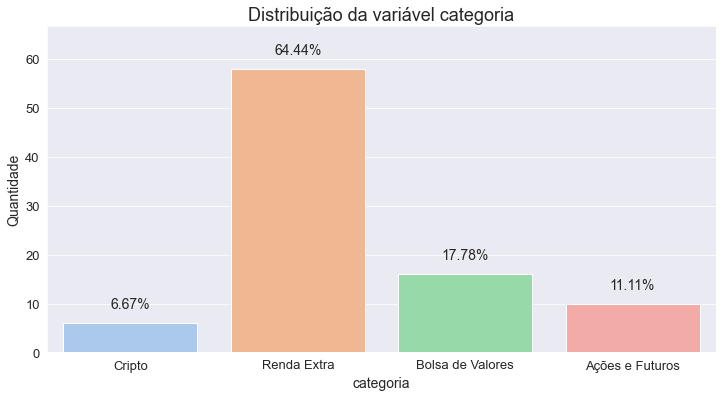

In [35]:
# Distribuição da variavel
fn_GrafBarras(empiricusProdutoCategoria, col='categoria')

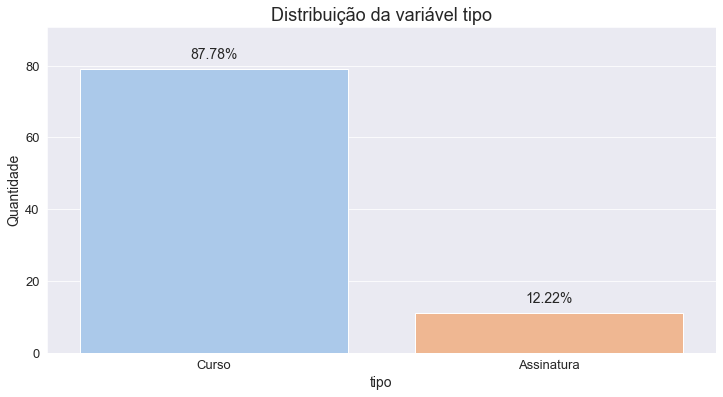

In [36]:
# Distribuição da variavel
fn_GrafBarras(empiricusProdutoCategoria, col='tipo')

##### Inclusão variável classificacao

Os produtos não possuem uma classificação de usuário, esta informação pode definir a popularidade do produto,
sendo assim, defini randomicamente os valores de 0 a 5 para cada produto do usuário, simulando que os usuários teriam classificado as assinaturas ou cursos, este procedimento não garante a veracidade da popularidade do produto, mas demonstra como esta informação nos ajuda na recomendação.


In [37]:
# gerando cópia do dataframe original
df = cadatroUsuarios.copy()

In [38]:
# Atribui as variaveis qtl e qtc os valores de quantidade de linha e quantidade de colunas do dataframe
qtl, qtc = df.shape

# Adicionando a variavel classificacao_usuario com valores randomicos de 0 a 5 para definir a nota da assinatura ou curso
df['classificacaoUsuario'] = [random.randint(0, 5) for _ in range(qtl)]

# Exibe a nova variável no dataframe
df.head(10)

,cpf,dataNascimento,cep,produto,ativo,pagamento,classificacaoUsuario
0,38005904843,2005-03-01,17505060,Crypto Staking,1,Carteiras Digitais,5
1,38005904843,2005-03-01,17505060,Lucrando com Automóveis 2.0,1,Boleto,2
2,38005904843,2005-03-01,17505060,Investidor Essencial com Felipe Miranda,1,Transferência,0
3,38005904843,2005-03-01,17505060,Vacas Leiteiras,1,Transferência,5
4,38005904843,2005-03-01,17505060,Os Melhores Fundos de Investimento,1,Boleto,2
5,38005904843,2005-03-01,17505060,Copy Camp Silver - Turma 2,0,Carteiras Digitais,4
6,28654921927,1991-10-24,31990490,Copy Camp - Silver,0,Carteiras Digitais,2
7,28654921927,1991-10-24,31990490,Investidor Definitivo,1,Boleto,3
8,93292205417,2003-08-24,20561094,Leilões de Alta Lucratividade 2.0,1,Transferência,5
9,93292205417,2003-08-24,20561094,Double Income,1,Cartão de Crédito,1


In [39]:
# Criando o dataframe com a popularidade do produto
classificacaoPopular = fn_classificacaoPopular(df, empiricusProdutoCategoria, userCol='cpf', itemCol='produto', classificacaoCol='classificacaoUsuario')
classificacaoPopular = classificacaoPopular.loc[:, ['produto', 'categoria', 'tipo', 'autor', 'qtclassificacao', 'mediaclassificacao', 'pontuacao']]
    
# Ordena o dataframe
classificacaoPopular = classificacaoPopular.sort_values('pontuacao', ascending = False)

# Exibe o dataframe
classificacaoPopular.head(10)

,produto,categoria,tipo,autor,qtclassificacao,mediaclassificacao,pontuacao
66,Mentoria Bitcamp,Renda Extra,Curso,Ray Nasser,3290,2.561,2.530
76,Opções de Alta Performance,Renda Extra,Curso,Ruy Hungria,3402,2.559,2.529
1,1 Milhão Rápido - Turma 4,Bolsa de Valores,Curso,Felipe Miranda,3388,2.554,2.526
75,O método dos 3%,Renda Extra,Curso,Rogério Araujo,3434,2.549,2.524
49,Leilões de Alta Lucratividade,Renda Extra,Curso,Lerry Granville,3450,2.548,2.524
64,Lucrando com Automóveis 7.0,Renda Extra,Curso,Lerry Granville,3391,2.549,2.524
83,Renda Imobiliária,Renda Extra,Assinatura,Caio Araujo,3410,2.543,2.521
59,Lucrando com Automóveis 2.0,Renda Extra,Curso,Lerry Granville,3326,2.544,2.521
50,Leilões de Alta Lucratividade 2.0,Renda Extra,Curso,Lerry Granville,3355,2.543,2.521
26,Copy Camp Upgrade,Renda Extra,Curso,Roberto Altenhofen,3425,2.542,2.521


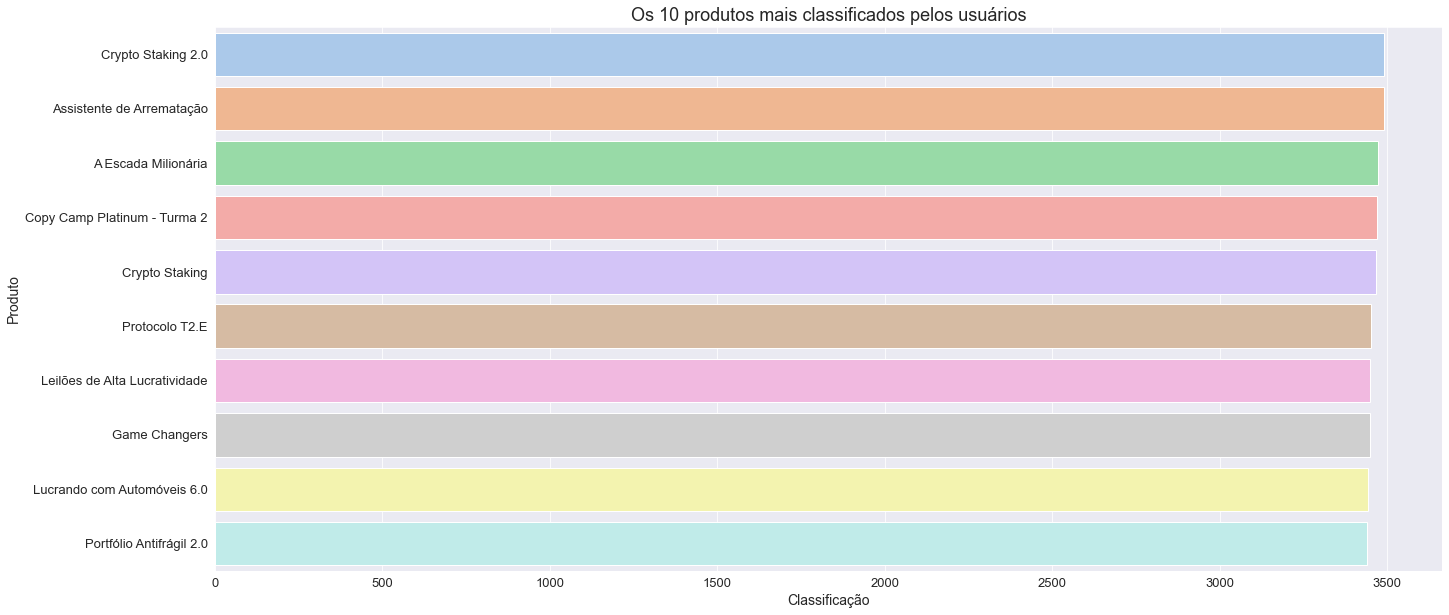

In [40]:
# Os 10 produtos mais classificados
plt.figure(figsize=(22, 10))
data = classificacaoPopular.sort_values(by='qtclassificacao', ascending=False).head(10)

g = sns.barplot(x='qtclassificacao', y='produto', data=data, palette=colors)
g.set_title(f"Os 10 produtos mais classificados pelos usuários")
g.set_xlabel(f"Classificação")
g.set_ylabel("Produto")
plt.show()

In [41]:
# Visualização dos 10 produtos mais populares, com maior pontuacao
classificacaoPopular.sort_values(by='pontuacao', ascending=False).head(10)


,produto,categoria,tipo,autor,qtclassificacao,mediaclassificacao,pontuacao
66,Mentoria Bitcamp,Renda Extra,Curso,Ray Nasser,3290,2.561,2.530
76,Opções de Alta Performance,Renda Extra,Curso,Ruy Hungria,3402,2.559,2.529
1,1 Milhão Rápido - Turma 4,Bolsa de Valores,Curso,Felipe Miranda,3388,2.554,2.526
75,O método dos 3%,Renda Extra,Curso,Rogério Araujo,3434,2.549,2.524
49,Leilões de Alta Lucratividade,Renda Extra,Curso,Lerry Granville,3450,2.548,2.524
64,Lucrando com Automóveis 7.0,Renda Extra,Curso,Lerry Granville,3391,2.549,2.524
83,Renda Imobiliária,Renda Extra,Assinatura,Caio Araujo,3410,2.543,2.521
59,Lucrando com Automóveis 2.0,Renda Extra,Curso,Lerry Granville,3326,2.544,2.521
50,Leilões de Alta Lucratividade 2.0,Renda Extra,Curso,Lerry Granville,3355,2.543,2.521
26,Copy Camp Upgrade,Renda Extra,Curso,Roberto Altenhofen,3425,2.542,2.521


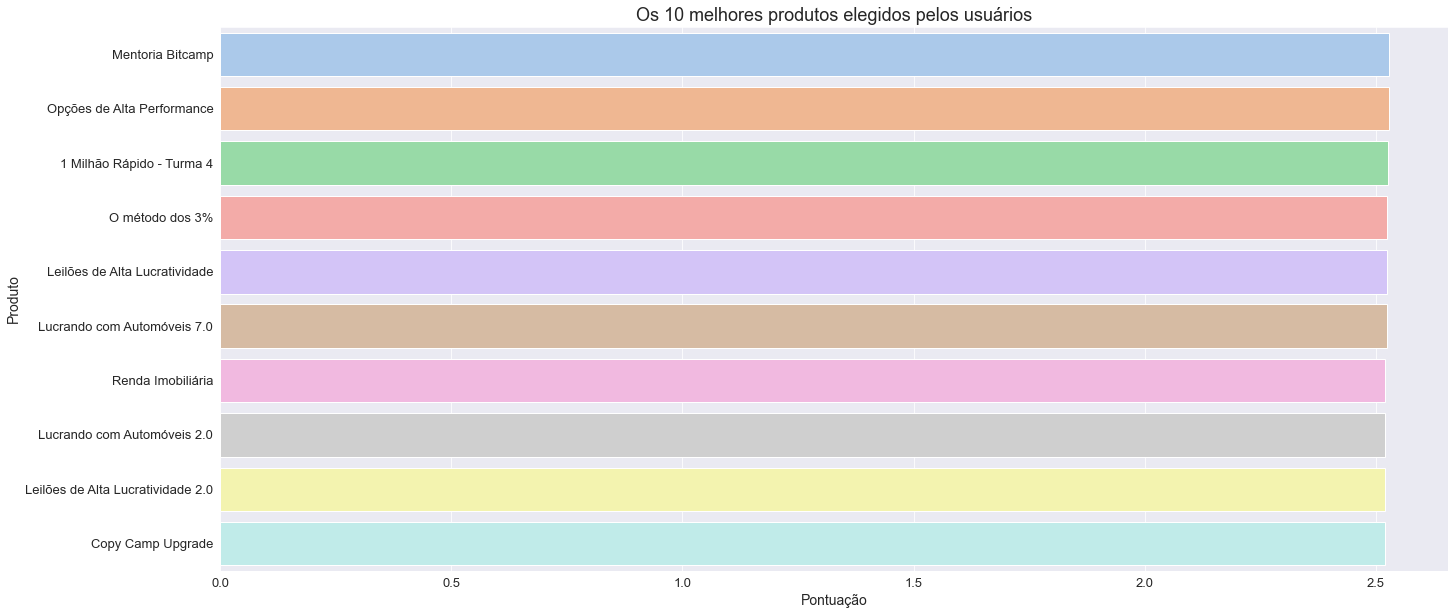

In [42]:
# Os 10 produtos mais pontuados
plt.figure(figsize=(22, 10))
data = classificacaoPopular.sort_values(by='pontuacao', ascending=False).head(10)

g = sns.barplot(x='pontuacao', y='produto', data=data, palette=colors)
g.set_title(f"Os 10 melhores produtos elegidos pelos usuários")
g.set_xlabel(f"Pontuação")
g.set_ylabel("Produto")
plt.show()

#### Concatenando Dataframe de Usuários e Produtos Classificados

In [43]:
# Avaliando os valores nulos do dataframe
missing_values_table(df)

O dataframe tem 7 colunas e 303967 linhas.
Existem 0 colunas que têm valores faltantes.


,Valores faltantes,% de Valores Totais,Data Type


In [44]:
print(f"Dataframe Usuários")
pd.DataFrame(df.columns.to_list(), columns=['Colunas'])

Dataframe Usuários


,Colunas
0,cpf
1,dataNascimento
2,cep
3,produto
4,ativo
5,pagamento
6,classificacaoUsuario


In [45]:
# Avaliando os valores nulos do dataframe
missing_values_table(classificacaoPopular)

O dataframe tem 7 colunas e 90 linhas.
Existem 0 colunas que têm valores faltantes.


,Valores faltantes,% de Valores Totais,Data Type


In [46]:
print(f"Dataframe Produtos")
pd.DataFrame(classificacaoPopular.columns.to_list(), columns=['Colunas'])

Dataframe Produtos


,Colunas
0,produto
1,categoria
2,tipo
3,autor
4,qtclassificacao
5,mediaclassificacao
6,pontuacao


In [47]:
# Concatenando o dataFrame de cadastro de usuário com o dataframe de produtos
df = pd.merge(df, classificacaoPopular, on='produto', how='outer')

### Análise exploratória

In [48]:
# Informações do dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 303967 entries, 0 to 303966
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   cpf                   303967 non-null  object 
 1   dataNascimento        303967 non-null  object 
 2   cep                   303967 non-null  int64  
 3   produto               303967 non-null  object 
 4   ativo                 303967 non-null  int64  
 5   pagamento             303967 non-null  object 
 6   classificacaoUsuario  303967 non-null  int64  
 7   categoria             303967 non-null  object 
 8   tipo                  303967 non-null  object 
 9   autor                 303967 non-null  object 
 10  qtclassificacao       303967 non-null  int64  
 11  mediaclassificacao    303967 non-null  float64
 12  pontuacao             303967 non-null  float64
dtypes: float64(2), int64(4), object(7)
memory usage: 32.5+ MB


In [49]:
#df.describe(include='all')  
df.describe()

,cep,ativo,classificacaoUsuario,qtclassificacao,mediaclassificacao,pontuacao
count,3.040e+05,303967.000,303967.000,303967.000,303967.000,303967.000
mean,4.595e+07,0.700,2.498,3378.204,2.498,2.498
std,2.987e+07,0.458,1.707,51.698,0.033,0.017
min,1.002e+06,0.000,0.000,3250.000,2.422,2.459
25%,1.830e+07,0.000,1.000,3344.000,2.470,2.484
50%,4.150e+07,1.000,2.000,3374.000,2.501,2.500
75%,7.426e+07,1.000,4.000,3419.000,2.522,2.510
max,9.996e+07,1.000,5.000,3490.000,2.561,2.530


In [50]:
# Quantidade de linhas e colunas
qtl, qtc = df.shape

# Quantidade de linhas duplicadas
qtd, _ = df[df.duplicated(keep=False)].shape

print(f'Quantidade de linhas...........: {qtl}')
print(f'Quantidade de linhas duplicadas: {qtd}')
print(f'Quantidade de colunas..........: {qtc}')

Quantidade de linhas...........: 303967
Quantidade de linhas duplicadas: 0
Quantidade de colunas..........: 13


#### Usuários (cpf)

In [51]:
ctUsuarios = df['cpf'].nunique()
print(f'Quantidade de usuários: {ctUsuarios}')

Quantidade de usuários: 40005


#### Produtos ativos

In [52]:
Counter(df['ativo'])

Counter({1: 212887, 0: 91080})

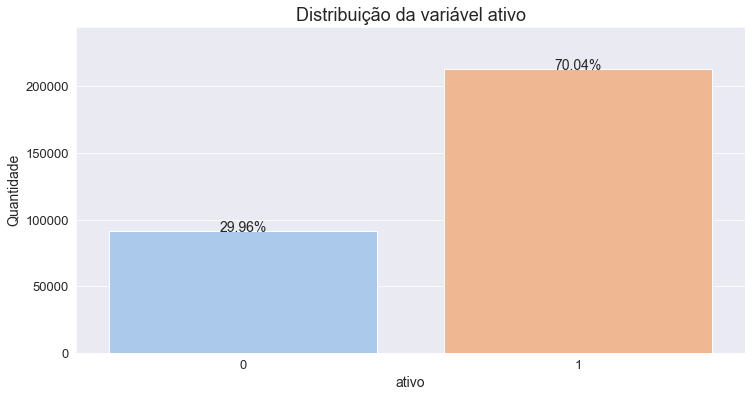

In [53]:
# Distribuição da variavel tipo de Curso
fn_GrafBarras(df, col='ativo')

#### Tipo de Produto (Assinaturas e Cursos)

In [54]:
Counter(df['tipo'])

Counter({'Curso': 267032, 'Assinatura': 36935})

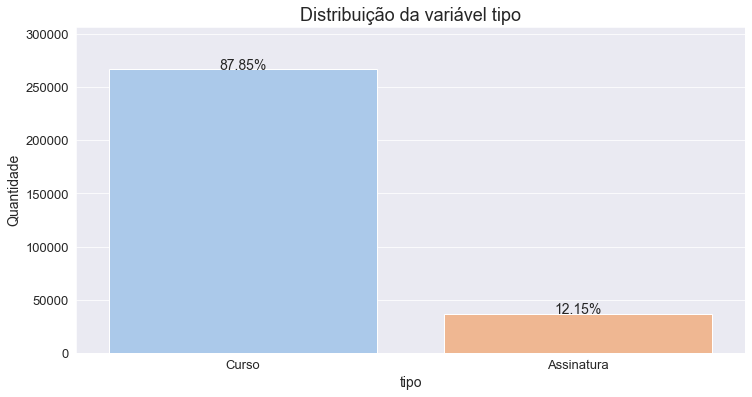

In [55]:
# Distribuição da variavel tipo de Curso
fn_GrafBarras(df, col='tipo')

#### Categoria do Produto

In [56]:
Counter(df['categoria'])

Counter({'Cripto': 20503,
         'Renda Extra': 196042,
         'Ações e Futuros': 33437,
         'Bolsa de Valores': 53985})

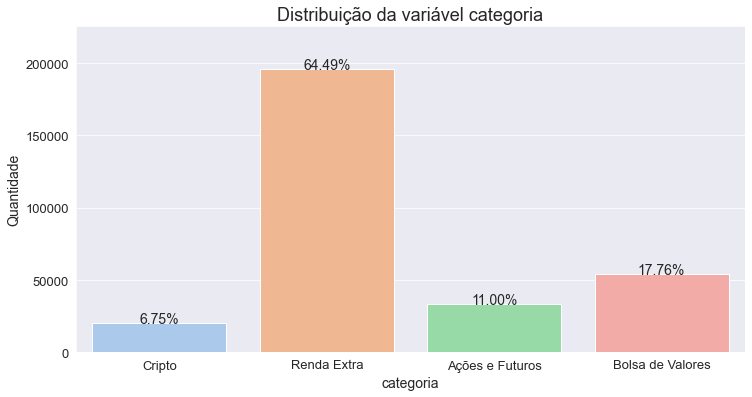

In [57]:
# Distribuição da variavel
fn_GrafBarras(df, col='categoria')

#### Pagamentos efetuados

In [58]:
Counter(df['pagamento'])

Counter({'Carteiras Digitais': 76176,
         'Boleto': 76451,
         'Cartão de Crédito': 75554,
         'Transferência': 75786})

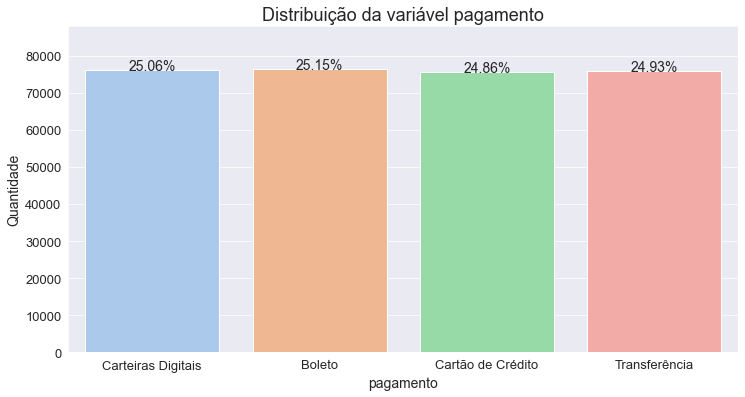

In [59]:
# Distribuição da variavel classificacao
fn_GrafBarras(df, col='pagamento')

### Treinamento do modelo

#### Filtragem colaborativa (produto recomedação)

Os modelos de filtragem colaborativa partem da ideia de que as pessoas que pensam da mesma forma tendem a dar ou receber pensamentos semelhantes. 
Sabemos também que normalmente usuários não avaliam todos os produtos. Um usuário classificará alguns produtos, mas quando um usuário classifica um par de produtos com classificações semelhantes a outro, podemos assumir que têm gostos semelhantes e depois, com base nessa suposição, podemos prever as classificações que faltam para outro usuário semelhante, completando assim os valores que faltam na matriz.

Em outras palavras, vamos transformar os gostos e aversões de cada usuário em vetores e comparar o ângulo entre esses vetores. 
Quanto mais baixo o ângulo, mais semelhantes são os usuários e o contrário também é verdadeiro, quanto mais alto o ângulo, mais diferentes tendem a ser.

In [60]:
# Criando dataframe 
dfModel = classificacaoPopular[['produto','mediaclassificacao', 'qtclassificacao','pontuacao']].set_index("produto")

# Leitura do dataframe utilizando a função surprise
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(dfModel, reader)

# Dividindo o conjunto de dados
trainset, testset = train_test_split(data, test_size=0.3, random_state=42)

# Criação de um modelo baseado em item (user_based true / false para alternar entre filtragem colaborativa baseada
# em usuário ou baseada em item)
algo = KNNWithMeans(k=5, sim_options={'user_based': False})
algo.fit(trainset)

# Teste do modelo
test_pred = algo.test(testset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [61]:
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 0.0165


0.016518192756976902

In [62]:
# Usando a função get_neighbors para obter as 10 recomendações de produto
recomendacao = algo.get_neighbors(0, 10)

# Visualização dos 10 produtos recomendados
# df_classificacao.iloc[recomendacao]#.index.values.tolist()
display(pd.DataFrame(dfModel.iloc[recomendacao].index.values.tolist(), columns=['produto']).style.hide_index())

produto
Opções de Alta Performance
1 Milhão Rápido - Turma 4
O método dos 3%
Leilões de Alta Lucratividade
Lucrando com Automóveis 7.0
Renda Imobiliária
Lucrando com Automóveis 2.0
Leilões de Alta Lucratividade 2.0
Copy Camp Upgrade
1 Milhão Rápido 2022


#### Sistema de filtragem colaborativa baseado em modelos

Este é um modelo Fatorização Matricial, tendo em consideração o nome do usuário e a identificação do produto para fazer as previsões.

Vou criar uma matriz de correlação a partir da matriz de decomposição utilizando a função TruncatedSVD.</br> 
Isso indicará que para cada usuário, vou calcular o quão semelhante ele é aos outros usuários.</br>
Na matrix o quanto mais se aproximar de 1, mais semelhante e quanto mais se aproximar de -1, mais diferente.

Este modelo consiste em receber o nome do produto que vai criar a correlação para todas as assinaturas e cursos (produtos) a partir do produto adquirido por este usuário com base nos produtos classificados por outros usuários que adquiriram o mesmo produto.

In [63]:
# Definição do Dataframe com a matrix de variáveis
df_classificacaoMatrix = df.pivot_table(values='classificacaoUsuario', index='cpf', columns='produto', fill_value=0)

# Transposição da matrix
X = df_classificacaoMatrix.T

# Decomposição da Matriz, a função SVD truncada irá reduzir a dimensão da matriz esparsa no número de componentes solicitados
SVD_model = TruncatedSVD(n_components=10)
decompostaMatrix = SVD_model.fit_transform(X)

# Matrix de correlação
correlacaoMatrix = np.corrcoef(decompostaMatrix)

In [64]:
# Escolher um produto da lista para obter as recomendações.
p = "Day Trade Academy"

produtos = list(X.index)
indiceProduto = produtos.index(p)

# Correlação para todas as assinaturas e cursos (produtos) a partir do produto adquirido por este usuário
# com base nos produtos classificados por outros usuários que adquiriram o mesmo produto.
correlacaoProduto = correlacaoMatrix[indiceProduto]

# Os 10 produtos similares ao produto escolhido.
recomendacao = list(X.index[correlacaoProduto > 0.65])

# Removendo o produto já comprado pelo cliente
recomendacao.remove(p)

# Visualização dos 10 produtos recomendados
# recomendacao[0:10]
display(pd.DataFrame(recomendacao[0:10],columns=['produto']).style.hide_index())

produto
A Sua Jornada Milionária - Turma 4
Assessor de Investimentos
Assistente de Arrematação
Assistente de Arrematação 3.0
Copy Camp - Platinum
Copy Camp Silver - Turma 2
Copywriter Freelancer em 21 Dias
CryptoXpress
Double Income
Empiricus Crypto Academy


#### Recomendação por produto x categoria x autor

In [69]:
# Escolher um produto da lista para obter as recomendações. 
p = "Day Trade Academy"

# Criando dataframe de produtos classificados
produtosClassCategoria = classificacaoPopular.reset_index(drop=False)
produtosClassificados = produtosClassCategoria.loc[produtosClassCategoria['produto'].isin(df['produto'])].copy()

# Criando novo dataframe de atributos dos produtos
atributo = produtosClassificados['categoria'].str.split(",", expand=True)

# Todos os atributos 
allatributo = set()
for e in atributo.columns:
    atributoUnico = atributo[e].str.lower().str.strip().unique()
    allatributo.update(atributoUnico)
#allatributo.remove(None)

# Criando dataframe
produtoMatrix = produtosClassificados[['produto', 'categoria','autor']].copy()
produtoMatrix['categoria'] = produtoMatrix['categoria'].str.lower().str.strip()
produtoMatrix['autor'] = produtoMatrix['autor'].str.lower().str.strip()

for e in allatributo:
    produtoMatrix[e] = np.where(produtoMatrix['categoria'].str.contains(e), 1, 0)
produtoMatrix = produtoMatrix.drop(['categoria'], axis=1)
produtoMatrix = produtoMatrix.drop(['autor'], axis=1)
produtoMatrix = produtoMatrix.set_index('produto')

# Criando matrix de relacionamento produto-genero
correlacao = cosine_similarity(produtoMatrix)

# obter os 10 produtos similares
ind2name = {ind:name for ind,name in enumerate(produtoMatrix.index)}
name2ind = {v:k for k,v in ind2name.items()}
recomendacao = fn_recomendacaoProdutos( name2ind[p],
                                        qtProduto = 10,
                                        corrMat = correlacao,
                                        mapName = ind2name)

print(f"10 recomendações de produtos baseado em produto x categoria x autor por utilizar o produto  {p}")
display(produtosClassCategoria.loc[produtosClassCategoria['produto'].isin(recomendacao)][['produto','categoria', 'autor']].style.hide_index())

del correlacao
gc.collect();

10 recomendações de produtos baseado em produto x categoria x autor por utilizar o produto  Day Trade Academy


produto,categoria,autor
1 Milhão Rápido 2022,Bolsa de Valores,Felipe Miranda
A Sua Jornada Milionária - Turma 3,Bolsa de Valores,Bettina Rudolph
1 Milhão Rápido,Bolsa de Valores,Felipe Miranda
1 Milhão Rápido 2021,Bolsa de Valores,Felipe Miranda
Seu Primeiro Trade,Bolsa de Valores,Filipe Fradinho
Day Trade Academy,Bolsa de Valores,Leandro Petrokas
Jornada com Milhas,Bolsa de Valores,Bettina Rudolph
Jornada da Liberdade Financeira,Bolsa de Valores,Rodolfo Amstalden
A Sua Jornada Milionária - Turma 2,Bolsa de Valores,Bettina Rudolph
A Pizza Milionária,Bolsa de Valores,Equipe Empiricus


#### Recomendação por produto x autor x categoria

In [70]:
# Escolher um produto da lista para obter as recomendações. 
p = "Day Trade Academy"

# Criando dataframe de produtos classificados
produtosClassCategoria = classificacaoPopular.reset_index(drop=False)
produtosClassificados = produtosClassCategoria.loc[produtosClassCategoria['produto'].isin(df['produto'])].copy()

# Criando novo dataframe de atributos dos produtos
atributo = produtosClassificados['autor'].str.split(",", expand=True)

# Todos os atributos 
allatributo = set()
for e in atributo.columns:
    atributoUnico = atributo[e].str.lower().str.strip().unique()
    allatributo.update(atributoUnico)
#allatributo.remove(None)

# Criando dataframe
produtoMatrix = produtosClassificados[['produto', 'autor', 'categoria']].copy()
produtoMatrix['autor'] = produtoMatrix['autor'].str.lower().str.strip()
produtoMatrix['categoria'] = produtoMatrix['categoria'].str.lower().str.strip()

for e in allatributo:
    produtoMatrix[e] = np.where(produtoMatrix['autor'].str.contains(e), 1, 0)
produtoMatrix = produtoMatrix.drop(['autor'], axis=1)
produtoMatrix = produtoMatrix.drop(['categoria'], axis=1)
produtoMatrix = produtoMatrix.set_index('produto')

# Criando matrix de relacionamento produto-genero
correlacao = cosine_similarity(produtoMatrix)

# obter os 10 produtos similares
ind2name = {ind:name for ind,name in enumerate(produtoMatrix.index)}
name2ind = {v:k for k,v in ind2name.items()}
recomendacao = fn_recomendacaoProdutos( name2ind[p],
                                        qtProduto = 10,
                                        corrMat = correlacao,
                                        mapName = ind2name)

print(f"10 recomendações de produtos baseado em produto x autor x categoria por utilizar o produto {p}")
display(produtosClassCategoria.loc[produtosClassCategoria['produto'].isin(recomendacao)][['produto','autor', 'categoria']].style.hide_index())

del correlacao
gc.collect();

10 recomendações de produtos baseado em produto x autor x categoria por utilizar o produto Day Trade Academy


produto,autor,categoria
Trader de Fim de Semana,Leandro Petrokas,Bolsa de Valores
Portfólio Antifrágil 2.0,Ruy Hungria,Ações e Futuros
Leilões de Alta Lucratividade 7.0,Lerry Granville,Renda Extra
Empiricus Crypto Legacy,Vinicius Bazan,Cripto
Protocolo T2.E,Andre Franco,Renda Extra
Leilões de Alta Lucratividade 3.0 - Silver,Lerry Granville,Renda Extra
Leilões de Alta Lucratividade 4.0 - Platinum,Lerry Granville,Renda Extra
Assistente de Arrematação 2.0,Lerry Granville,Renda Extra
Day Trade Academy,Leandro Petrokas,Bolsa de Valores
O Método Caixa Preta,Amanda Holzer,Renda Extra
